### Imports

In [75]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import json
import timeit
import soundfile
import glob
import os
from IPython.display import Audio, display
from librosa.display import waveshow, specshow

### Constants

In [99]:
# sampling rate 
sr = 16000

# path of a random sample
FILE_PATH = './data/train/clean/p237_084.wav'

# Full-Scale (in dB) for RMS-normalization
FS = -25

# Frame-size: Number of samples in a frame
n_fft = 512 

# Number of samples between two adjacent frames (here, 75 % overlap between frames)
hop_length = 512 // 4 

# Number of frequency bins
n_bins = n_fft // 2 + 1 

# Lower bound for SNR values
SNR_LB = 0.1

# Upper bound for SNR values
SNR_UB = 0.5

# Subset-size (taking only a subset of the original dataset due to hardware constraints)
TRAIN_SIZE = 10000

# duration of each audio sample in seconds
AUDIO_LEN = 3  

# Total samples in an audio file of duration: AUDIO_LEN and sampling-rate: sr
n_samples = AUDIO_LEN * sr

# Number of frames in a spectrogram with total-samples: n_samples, frame-size: n_fft and hop-size: hop_length
n_frames = (n_samples - n_fft) // hop_length + 1

print(f'Total number of frames: {n_frames}') # calculated value of n_frames

Total number of frames: 372


### Util Functions

In [77]:
# Function to play audio in cell output
def play_audio(signal):
    """
    Plays the given audio signal.

    Args:
        signal (numpy.ndarray): The audio signal to be played.
        
    Returns:
        None: The audio signal is played directly.
    """
    
    # normalize := False, so that we can hear the effect of aplitude changes
    display(Audio(data = signal, rate = sr, normalize = False))


In [78]:
# function to perform RMS-Normalization to dBFS
def normalize(signal):
    """
    Normalizes the given signal using RMS normalization.

    Args:
        signal (numpy.ndarray): The signal to be normalized.

    Returns:
        numpy.ndarray: The normalized signal.

    Raises:
        ValueError: If the input signal is empty or contains only zeros.
    """
    
    # RMS-Noramalization as follows:
    # dBFS (needed) = 20 * log(rms_new / rms_max)
    # rms_new = (10 ** (dBFS(needed) / 20)) * rms_max
    # rms_new = alpha * rms_signal
    # alpha * rms_signal = (10 ** (dBFS(needed) / 20)) * rms_max
    # alpha = (10 ** (dBFS(needed) / 20)) * rms_max / rms_signal
    # rms_max = 1
    # alpha = (10 ** (dBFS(needed) / 20)) / rms_signal
    
    # to avoid division-by-zero
    if len(signal) == 0 or np.all(signal == 0):
        raise ValueError("Input signal cannot be empty or contain only zeros.")
    
    rms_signal = np.sqrt(np.mean(signal ** 2))
    
    scaling_factor = (10 ** (FS / 20)) / rms_signal
    
    signal = signal * scaling_factor # scaling the signal
    
    return signal


In [79]:
# Function to perform 'clipping' to [-1, 1] on the signal
def clip(signal):
    """
    Clips the values in the given signal array to a range of -1 to 1.

    Args:
        signal (numpy.ndarray): The signal to be clipped.

    Returns:
        None: Modifies the input signal in-place.
    """
    
    for i in range(len(signal)):
        if(signal[i] > 1):
            signal[i] = 1 # positive hardlimit    
        elif(signal[i] < -1):
            signal[i] = -1 # negative hardlimit
            
            

In [80]:
# Function to mix noise with clean audio signal at a particular SNR
def get_noisy(clean, noise, snr):
    """
    Generates a noisy signal by combining a clean signal and a noise signal according to a desired SNR (signal-to-noise ratio).
    
    Args:
        clean (numpy.ndarray): The clean signal.
        noise (numpy.ndarray): The noise signal.
        snr (float): The desired SNR level.

    Returns:
        numpy.ndarray: The resulting noisy signal.

    Raises:
        ValueError: If the clean or noise signals are empty or contain only zeros.
    """
    # To avoid division-by-zero
    if len(clean) == 0 or np.all(clean == 0) or len(noise) == 0 or np.all(noise == 0):
        raise ValueError("Clean and noise signals cannot be empty or contain only zeros.")
    
    # Noramlizing the clean and noise signals
    clean = normalize(clean)
    noise = normalize(noise)
    
    # Mixing to desired SNR as follows:
    # snr = 20 * log(rms_signal / rms_noise)
    # rms_noise = rms_signal / (10 ** (snr / 20))
    # rms_noise_current * alpha = rms_signal / (10 ** (snr / 20))
    # alpha = rms_signal / (10 ** (snr / 20)) / rms_noise_current
    
    # RMS values of clean and noise signals
    rms_clean = np.sqrt(np.mean(clean ** 2))
    rms_noise = np.sqrt(np.mean(clean ** 2))
    
    scaling_factor = rms_clean / (10 ** (snr / 20)) / rms_noise
    
    # Getting scaled noise with desired RMS value
    noise = noise * scaling_factor
    
    # Adding noise to the clean signal
    noisy = clean + noise
    
    # Clipping the generated noisy signal
    clip(noisy)
    
    return noisy


In [81]:
# Function to add a symmetric zero-padding on both sides of a signal
def pad_signal(signal, n_pad):
    """
    Pads the given signal with zeros on both sides.

    Args:
        signal (numpy.ndarray): The input signal to be padded.
        n_pad (int): The number of zero samples to be added to the signal.

    Returns:
        numpy.ndarray: The padded signal.
    """
    
    padded_signal = np.zeros(len(signal) + n_pad)
    
    start = n_pad >> 1
    padded_signal[start : start + len(signal)] = signal
    
    return padded_signal

### Clean and Noise Files

In [82]:
# Directory of noise files
noise_dir = './data/train/noise/'

# Directory of clean files
clean_dir = './data/train/clean/'

# Loading the relative-path/names of all noise-files [.wav]
noise_filenames = glob.glob(os.path.join(noise_dir, '*.wav'))

print(f'Total number of noise-files: {len(noise_filenames)}')

# Loading all the relative-path/names of clean-files [.wav]
clean_filenames = glob.glob(os.path.join(clean_dir, '*.wav'))

print(f'Total number of clean-files: {len(clean_filenames)}')

Total number of noise-files: 128
Total number of clean-files: 23075


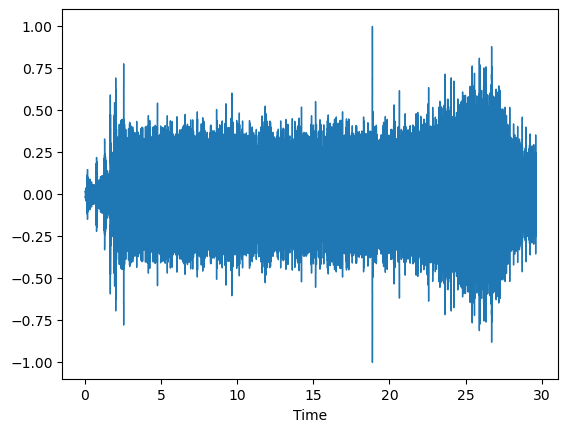

In [83]:
# A random noise sample
random_noise = noise_filenames[np.random.randint(len(noise_filenames))]

noise, _ = librosa.load(random_noise, sr = sr) # load the random noise-sample

waveshow(noise, sr = sr) # waveform of of the sample

play_audio(noise) # listen to the random noise-sample

### Taking a subset of training clean audio samples

We will take all noise files, but only take a subset of clean samples because of hardware constraints

In [84]:
# Picking random clean audio samples
selected_samples = np.arange(len(clean_filenames))
np.random.shuffle(selected_samples)
selected_samples = selected_samples[:TRAIN_SIZE]

files = [clean_filenames[idx] for idx in selected_samples]

clean_filenames = files

### Adding Noise to Clean files

In [85]:
# Destination directories for processed files
noisy_dir = './data/processed/train/noisy/'
clean_dir = './data/processed/train/clean/'

assert os.path.exists(noisy_dir), 'noisy_dir does not exist'
assert os.path.exists(clean_dir), 'clean_dir does not exist'

In [86]:
# Analyzing the length of 'clean' audio samples

# duration[i] => number of clean files with duration less than 'i' seconds.
durations = [0, 0, 0, 0] 

for filename in clean_filenames:
    signal, _ = librosa.load(filename, sr = sr)
    for i in range(1, AUDIO_LEN + 1):
        if(len(signal) < i * sr):
            durations[i] += 1
            break;

print(durations)

[0, 0, 1051, 5315]


As we can see there are a lot of clean files whose duration is less than AUDIO_LEN seconds. We will pad these signals with zeros on both sides to make their length equal to n_samples

In [88]:
clean_name = clean_filenames[np.random.randint(len(clean_filenames))] # random clean audio file

signal, _ = librosa.load(clean_name, sr = sr) # load clean audio file
play_audio(signal) 

signal = pad_signal(signal, n_samples - signal.size) # padding the clean signal
play_audio(signal)

In [89]:
noise_name = noise_filenames[np.random.randint(len(noise_filenames))] # random noise file

noise, _ = librosa.load(noise_name, sr = sr)

play_audio(noise)

In [90]:
cnt = 0

for fname in noise_filenames:
    s, _ = librosa.load(fname, sr = sr)
    if(len(s) <= sr):
        cnt += 1
                
print(cnt) # 0: number of noise files with duration less than or equal to AUDIO_LEN

0


There are no noise files with duration less than or equal to AUDIO_LEN. Hence, we don't need to pad the noise files. However, we would be randomly selecting a window (subarray) of the samples of length n_samples while mixing noise and clean signals.

#### Mixing two random noise and clean samples

In [91]:
# Picking a random window for noise
start = np.random.randint(len(noise) - n_samples)
noise = noise[start: start + n_samples]
play_audio(noise)

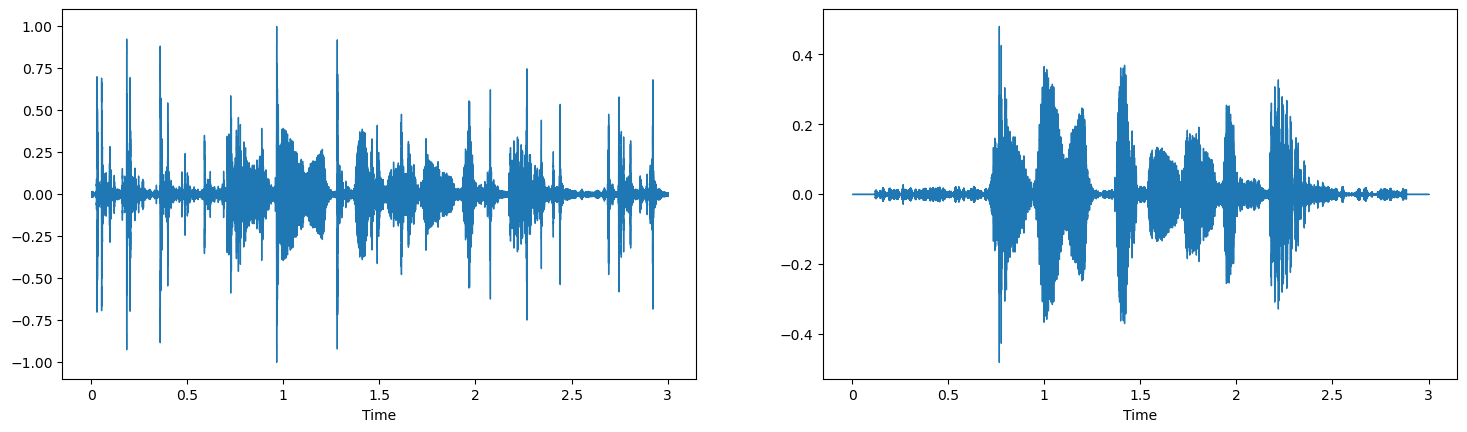

In [93]:
snr = np.random.uniform(SNR_LB, SNR_UB) # random SNR level

noisy = get_noisy(signal, noise, snr) # noisy signal (clean + noise)

# Plotting waveforms of noisy and clean signals
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(18)

waveshow(noisy, sr = sr, ax = axs[0])
waveshow(signal, sr = sr, ax = axs[1])

clip(noisy)

play_audio(noisy)

#### Mixing all selected clean files with some random noise

In [94]:
for clean_name in clean_filenames:
    # Load clean signal
    clean_signal, _ = librosa.load(clean_name, sr = sr)
    
    # Slicing the clean signal
    if(clean_signal.size > n_samples):
        clean_signal = clean_signal[:n_samples]
    
    # Padding the clean signal
    clean_signal = pad_signal(clean_signal, n_samples - len(clean_signal))
    
    # Picking a random noise
    noise_name = noise_filenames[np.random.randint(len(noise_filenames))]
    
    # Load the random noise
    noise, _ = librosa.load(noise_name, sr = sr)
    
    # Randomly picking a window of noise signal
    start = np.random.randint(len(noise) - n_samples)
    noise = noise[start: start + n_samples]
    
    # Randomly selecting SNR level for mixing
    snr = np.random.uniform(SNR_LB, SNR_UB)
    
    assert clean_signal.size == noise.size, "clean_signal and noise have unequal lengths"
    
    # Mixing clean and noise signals
    noisy = get_noisy(clean_signal, noise, snr)
    
    # Storing the (noisy, clean) : (input, target) pairs for supervised learning
    new_name = os.path.basename(clean_name) + '&' + os.path.basename(noise_name)
    
    new_clean_name = os.path.join(clean_dir, new_name)
    new_noise_name = os.path.join(noisy_dir, new_name)
    
    soundfile.write(new_clean_name, clean_signal, sr)
    soundfile.write(new_noise_name, noisy, sr)
    
    

In [95]:
noisy_filenames = glob.glob(os.path.join(noisy_dir, '*&*.wav'))
print(len(noisy_filenames))

10000


In [96]:
# for fname in noisy_filenames:
#     os.remove(fname)

In [97]:
clean_filenames = glob.glob(os.path.join(clean_dir, '*&*.wav'))
print(len(clean_filenames))

10000


In [98]:
# for fname in clean_filenames:
#     os.remove(fname)